In [1]:
from itertools import combinations, permutations
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

from source.moreka import AxonData
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics.pairwise import euclidean_distances
# from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
# from scipy.stats import poisson
# import tensorflow as tf
# from tensorflow import keras
# from keras.layers import Input, LSTM, RepeatVector
# from keras.models import Model
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
# import mdn
# import plotly.express as px
from sympy import symbols, Eq, solve
from sim import generate, moving_average
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt


We want to imitate the noise in the data. We first try to figure out the distribution of the noise in the data. We can do this by plotting the histogram of the residuals. The residuals are the difference between the actual values and the predicted values. We can get the residuals by subtracting the predicted values from the actual values. We can then plot the histogram of the residuals to see the distribution of the noise in the data.

(600000,)


(21.5, 22.5)

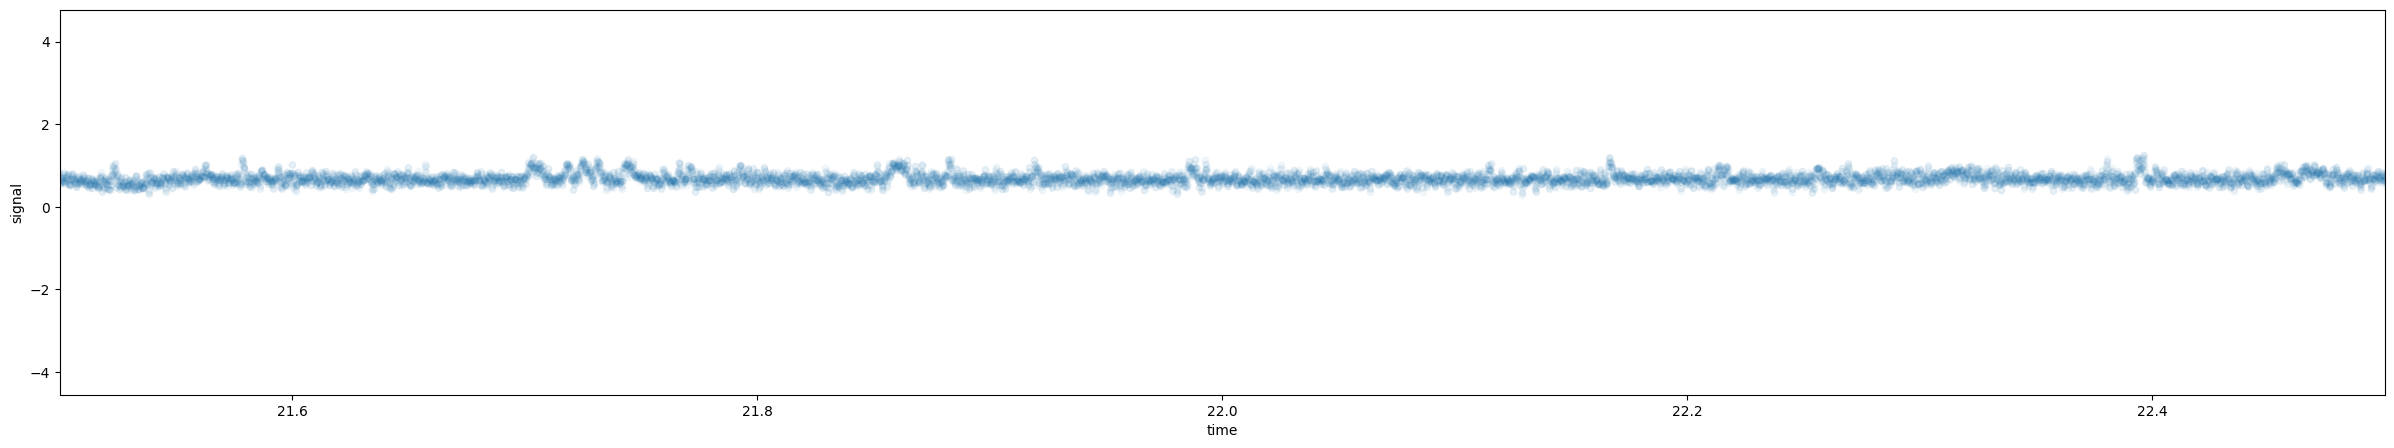

In [10]:
data = AxonData(dirname='./data')
df = data[41].iloc[::, :]

print(df.signal.shape)
df.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=0.05)
plt.xlim(21.5, 22.5)

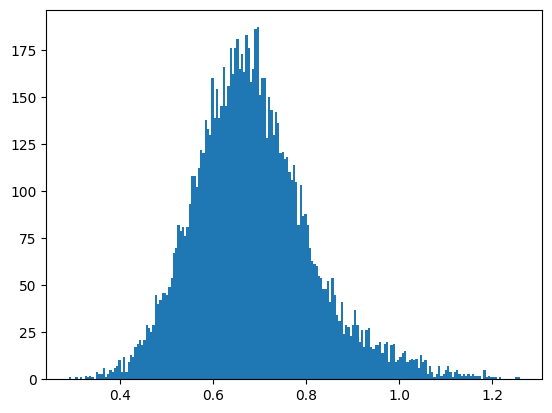

In [11]:
# for only signal between 14 and 16.5 
df = df[(df.time >= 21.5) & (df.time <= 22.5)]
# histogram
bins = np.linspace(df.signal.min(), df.signal.max(), 200)
hist = plt.hist(df.signal, bins=bins, alpha=1)
plt.show()

In [12]:
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))
        
        except Exception:
            pass

    
    return sorted(best_distributions, key=lambda x:x[2])


In [13]:
def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf


In [14]:
# find the best distribution for the signal
best_distributions = best_fit_distribution(df.signal, bins=200)
best_distributions

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

[(<scipy.stats._continuous_distns.burr12_gen at 0x122c234c0>,
  (9.67207842139769,
   1.0460073977533146,
   -0.014065755364345402,
   0.6935345243142319),
  3.1973635959993247),
 (<scipy.stats._continuous_distns.fisk_gen at 0x122c1b5e0>,
  (9.757330823444683, -0.009606859913546656, 0.6842326225625585),
  3.2463388832565565),
 (<scipy.stats._continuous_distns.burr_gen at 0x122c1b580>,
  (9.960008241100542,
   1.0264495231086224,
   -0.029911185067105776,
   0.701912075440108),
  3.2594380384289106),
 (<scipy.stats._continuous_distns.mielke_gen at 0x1233a6490>,
  (12.73220358725368,
   10.610417178540544,
   -0.1143809243156105,
   0.7701042617444922),
  3.4656725678698703),
 (<scipy.stats._continuous_distns.exponnorm_gen at 0x122c23160>,
  (0.9995956312597163, 0.594835074640343, 0.09119492129711748),
  3.5898564919851466),
 (<scipy.stats._continuous_distns.genlogistic_gen at 0x12317e550>,
  (2.3683179571438697, 0.5798188017583313, 0.08749628551194094),
  3.6032895107757117),
 (<scipy.s

In [15]:
# assuming that it is genhyperbolic, find the parameters
dist = best_distributions[0]
params = best_distributions[0][1]
params

(9.67207842139769,
 1.0460073977533146,
 -0.014065755364345402,
 0.6935345243142319)

<Axes: ylabel='Frequency'>

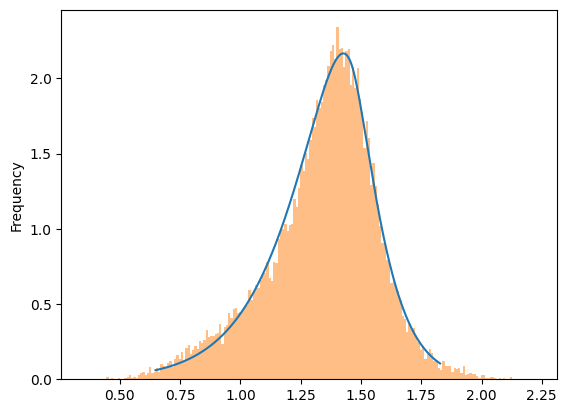

In [68]:
# recreate the genhyperbolic distribution with the parameters
pdf = make_pdf(dist, params, size=10000)
pdf.plot()
df.signal.plot(kind='hist', bins=200, density=True, alpha=0.5)

(array([0.01487932, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01487932, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01487932, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01487932, 0.        , 0.02975864, 0.01487932,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01487932, 0.01487932, 0.01487932,
        0.02975864, 0.02975864, 0.        , 0.01487932, 0.05951728,
        0.04463796, 0.        , 0.01487932, 0.05951728, 0.01487932,
        0.05951728, 0.04463796, 0.04463796, 0.02975864, 0.01487932,
        0.05951728, 0.04463796, 0.04463796, 0.08927592, 0.04463796,
        0.02975864, 0.05951728, 0.1487932 , 0.02

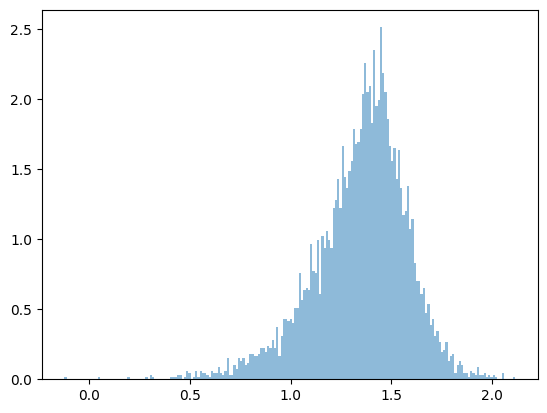

In [97]:
genhyperbolic = st.genhyperbolic
# from params
arg = params[:-2]
loc = params[-2]
scale = params[-1]
# Get sane start and end points of distribution
start = genhyperbolic.ppf(0.01, *arg, loc=loc, scale=scale) if arg else genhyperbolic.ppf(0.01, loc=loc, scale=scale)
end = genhyperbolic.ppf(0.99, *arg, loc=loc, scale=scale) if arg else genhyperbolic.ppf(0.99, loc=loc, scale=scale)

# generate random numbers from the distribution
r = genhyperbolic.rvs(*params, size=6000)
plt.hist(r, bins=200, density=True, alpha=0.5)

<Axes: xlabel='time', ylabel='signal'>

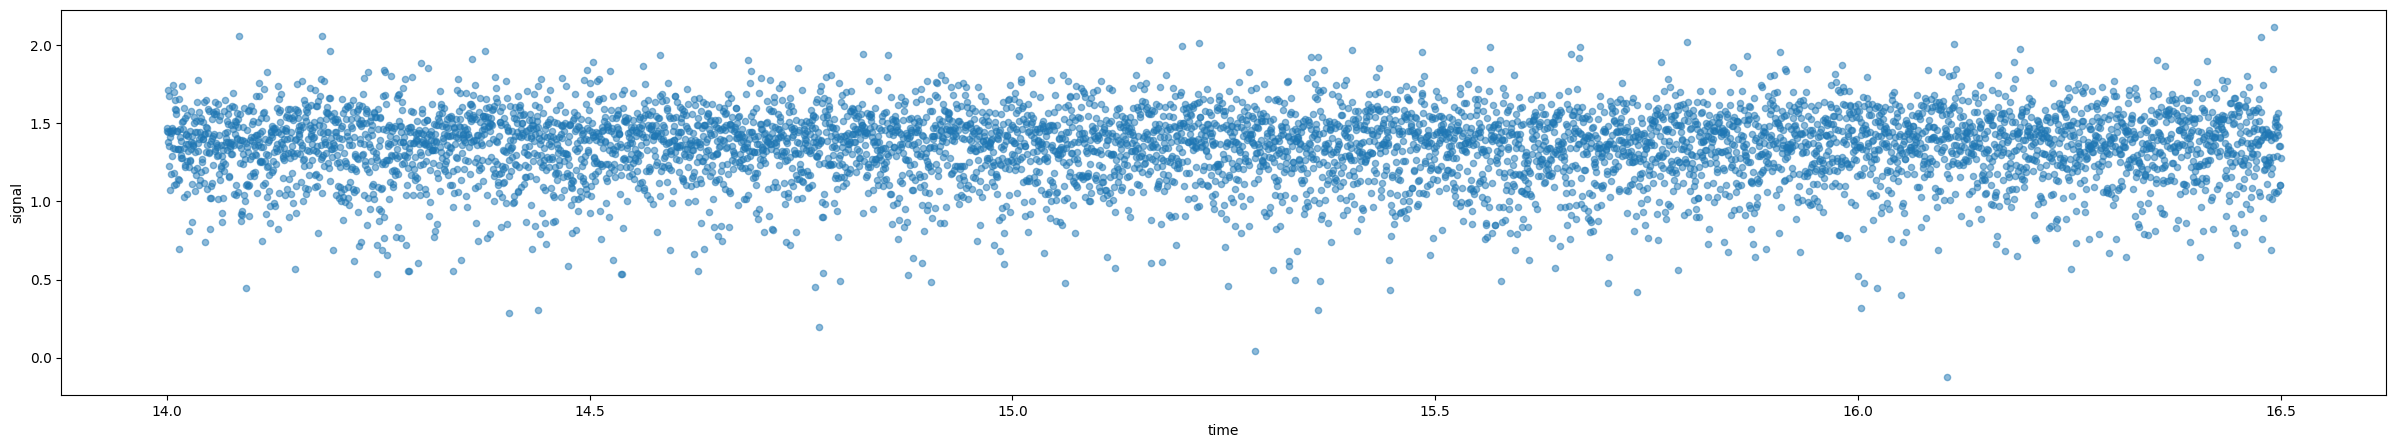

In [99]:
# create a signal with the generated random numbers
sim = pd.DataFrame({'time': np.linspace(14, 16.5, 6000), 'signal': r})
sim.plot(x='time', y='signal', figsize=(30, 5), kind='scatter', alpha=0.5)
